In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE,SequentialFeatureSelector
from tqdm import tqdm
from imblearn.pipeline import Pipeline

import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
rs = 0

In [2]:
processed_train_data = pd.read_csv("Processed_train_data.csv")
processed_test_data = pd.read_csv("Processed_test_data.csv")

In [3]:
processed_train_data.head()

,duration,protocol_type_icmp,protocol_type_tcp,protocol_type_udp,service,flag,src_bytes,dst_bytes,land,wrong_fragment,...,diff_srv_rate,srv_diff_host_rate,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_srv_serror_rate,class
0,0.0,0.0,1.0,0.0,0.273363,0.145284,0.009003,0.000000,0.0,0.0,...,0.00,0.00,0.588235,0.098039,0.17,0.03,0.17,0.00,0.00,0
1,0.0,0.0,0.0,1.0,0.389904,0.145284,0.002677,0.000000,0.0,0.0,...,0.15,0.00,1.000000,0.003922,0.00,0.60,0.88,0.00,0.00,0
2,0.0,0.0,1.0,0.0,0.953923,0.989729,0.000000,0.000000,0.0,0.0,...,0.07,0.00,1.000000,0.101961,0.10,0.05,0.00,0.00,1.00,1
3,0.0,0.0,1.0,0.0,0.056722,0.145284,0.004254,0.329867,0.0,0.0,...,0.00,0.00,0.117647,1.000000,1.00,0.00,0.03,0.04,0.01,0
4,0.0,0.0,1.0,0.0,0.056722,0.145284,0.003649,0.016993,0.0,0.0,...,0.00,0.09,1.000000,1.000000,1.00,0.00,0.00,0.00,0.00,0


In [4]:
processed_train_data_trX = processed_train_data.drop(columns=["class"],axis=1)
processed_train_data_trY = processed_train_data["class"]

In [5]:
processed_test_data_X = processed_test_data.drop(columns=["class"],axis=1)
processed_test_data_Y = processed_test_data["class"]

In [6]:
from imblearn.over_sampling import ADASYN, SMOTE
adasyn = ADASYN(random_state=rs)
smote = SMOTE(random_state=rs)

processed_smote_train_data_trX, processed_smote_train_data_trY = smote.fit_resample(processed_train_data_trX, processed_train_data_trY)

In [7]:
processed_adasyn_train_data_trX, processed_adasyn_train_data_trY = adasyn.fit_resample(processed_train_data_trX, processed_train_data_trY)

In [8]:
processed_smote_train_data = processed_smote_train_data_trX
processed_smote_train_data["class"] = processed_smote_train_data_trY

In [9]:
processed_smote_train_data["class"].value_counts()

0    64928
1    64928
Name: class, dtype: int64

In [10]:
processed_smote_train_data.to_csv("processed_smote_train_data.csv",index=False)

In [11]:
processed_adasyn_train_data = processed_adasyn_train_data_trX
processed_adasyn_train_data["class"] = processed_adasyn_train_data_trY

In [12]:
processed_adasyn_train_data["class"].value_counts()

0    64928
1    64813
Name: class, dtype: int64

In [13]:
processed_train_data["class"].value_counts()

0    64928
1    57709
Name: class, dtype: int64

In [14]:
processed_adasyn_train_data.to_csv("processed_adasyn_train_data.csv",index=False)

In [15]:
processed_smote_train_data_trX = processed_smote_train_data.drop(columns=["class"],axis=1)
processed_smote_train_data_trY = processed_smote_train_data["class"]

processed_adasyn_train_data_trX = processed_adasyn_train_data.drop(columns=["class"],axis=1)
processed_adasyn_train_data_trY = processed_adasyn_train_data["class"]

In [16]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix,f1_score,precision_score,recall_score,RocCurveDisplay,PrecisionRecallDisplay

In [17]:
#Function to obtain different metrics based on predicted class labels
def print_metrics(y_test,y_pred,name):
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.xlabel("Predicted Labels")
    plt.ylabel("Actual Labels")
    plt.title("Confusion Matrix Obtained")
    plt.show();
    accuracy_value = round(accuracy_score(y_test,y_pred),4)
    f1_value = round(f1_score(y_test,y_pred,labels=np.unique(y_pred)),4) 
    prec = round(precision_score(y_test,y_pred,labels=np.unique(y_pred)),4)
    rec = round(recall_score(y_test,y_pred,labels=np.unique(y_pred)),4)
    print("Accuarcy value obtained is ",accuracy_value)
    print("F1-score obtained is ",f1_value)
    print("Precision obtained is ",prec)
    print("Recall obtained is ",rec)
    roc_display = RocCurveDisplay.from_predictions(y_test,y_pred,name=name)
    _ = roc_display.ax_.set_title("ROC curve")
    pr_display = PrecisionRecallDisplay.from_predictions(y_test, y_pred, name=name)
    _ = pr_display.ax_.set_title("Precision-Recall curve")
    return [accuracy_value,f1_value,prec,rec]

In [18]:
dt_results_table = []

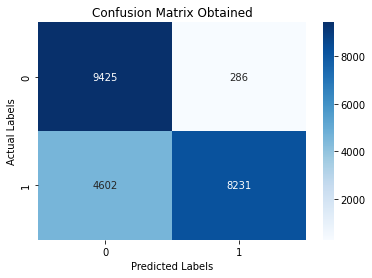

Accuarcy value obtained is  0.7832
F1-score obtained is  0.7711
Precision obtained is  0.9664
Recall obtained is  0.6414


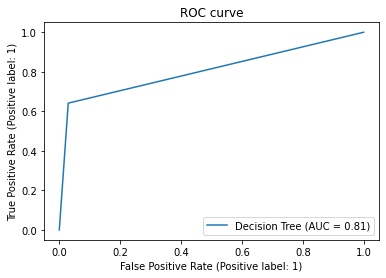

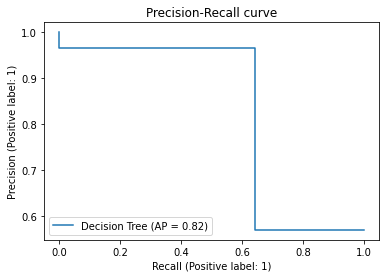

In [19]:
dt = DecisionTreeClassifier(random_state=rs)
dt.fit(processed_train_data_trX,processed_train_data_trY)
dt_yPred = dt.predict(processed_test_data_X)
#Performance Metrics obtained using Decision Tree
dt_list = ["Decision Tree"]
dt_list.extend(print_metrics(processed_test_data_Y, dt_yPred,"Decision Tree"))
dt_results_table.append(dt_list)

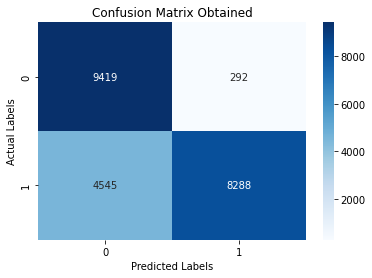

Accuarcy value obtained is  0.7854
F1-score obtained is  0.7741
Precision obtained is  0.966
Recall obtained is  0.6458


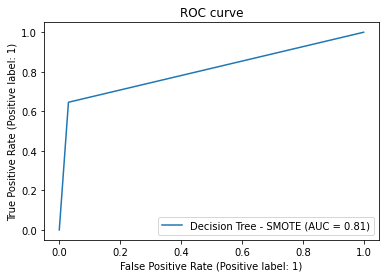

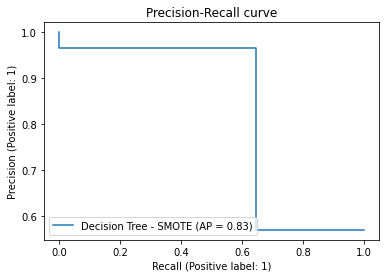

In [20]:
dt_smote = DecisionTreeClassifier(random_state=rs)
dt_smote.fit(processed_smote_train_data_trX,processed_smote_train_data_trY)
dt_smote_yPred = dt_smote.predict(processed_test_data_X)
#Performance Metrics obtained using Decision Tree
dt_list = ["Decision Tree - SMOTE"]
dt_list.extend(print_metrics(processed_test_data_Y, dt_smote_yPred,"Decision Tree - SMOTE"))
dt_results_table.append(dt_list)

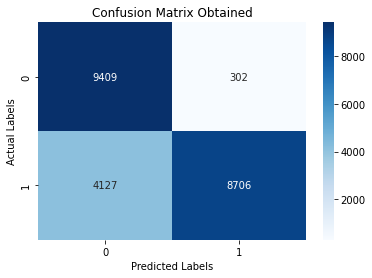

Accuarcy value obtained is  0.8035
F1-score obtained is  0.7972
Precision obtained is  0.9665
Recall obtained is  0.6784


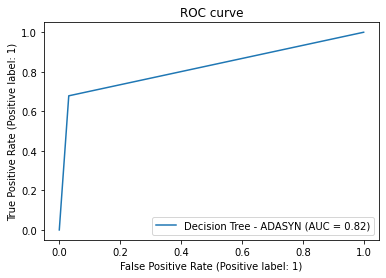

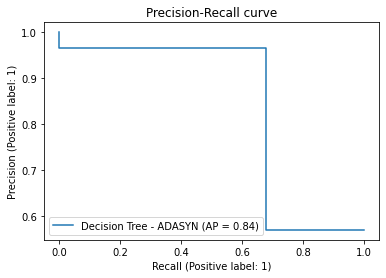

In [21]:
dt_adasyn = DecisionTreeClassifier(random_state=rs)
dt_adasyn.fit(processed_adasyn_train_data_trX,processed_adasyn_train_data_trY)
dt_adasyn_yPred = dt_adasyn.predict(processed_test_data_X)
#Performance Metrics obtained using Decision Tree
dt_list = ["Decision Tree - ADASYN"]
dt_list.extend(print_metrics(processed_test_data_Y, dt_adasyn_yPred,"Decision Tree - ADASYN"))
dt_results_table.append(dt_list)

In [22]:
#Hyperparameter Tuning of Decision Tree Classifier
from sklearn.model_selection import GridSearchCV
rs = 0

dt = DecisionTreeClassifier(random_state=rs)
params = {
    'max_depth': [2, 3, 5, 10, 20, 30, 40, 50, 100],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "f1")
grid_search.fit(processed_train_data_trX,processed_train_data_trY)
print(grid_search.best_estimator_)
print(grid_search.best_estimator_.get_params())

Fitting 5 folds for each of 90 candidates, totalling 450 fits
DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5,
                       random_state=0)
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}


In [23]:
#Hyperparameter Tuning of Decision Tree Classifier
from sklearn.model_selection import GridSearchCV
rs = 0

dt = DecisionTreeClassifier(random_state=rs)
params = {
    'max_depth': [2, 3, 5, 10, 20, 30, 40, 50, 100],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "f1")
grid_search.fit(processed_smote_train_data_trX,processed_smote_train_data_trY)
print(grid_search.best_estimator_)
print(grid_search.best_estimator_.get_params())

Fitting 5 folds for each of 90 candidates, totalling 450 fits
DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,
                       random_state=0)
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}


In [24]:
#Hyperparameter Tuning of Decision Tree Classifier
from sklearn.model_selection import GridSearchCV
rs = 0

dt = DecisionTreeClassifier(random_state=rs)
params = {
    'max_depth': [2, 3, 5, 10, 20, 30, 40, 50, 100],
    'min_samples_leaf': [5, 10, 20, 50, 100],
    'criterion': ["gini", "entropy"]
}
grid_search = GridSearchCV(estimator=dt, 
                           param_grid=params, 
                           cv=5, n_jobs=-1, verbose=1, scoring = "f1")
grid_search.fit(processed_adasyn_train_data_trX,processed_adasyn_train_data_trY)
print(grid_search.best_estimator_)
print(grid_search.best_estimator_.get_params())

Fitting 5 folds for each of 90 candidates, totalling 450 fits
DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,
                       random_state=0)
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 20, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 5, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'random_state': 0, 'splitter': 'best'}


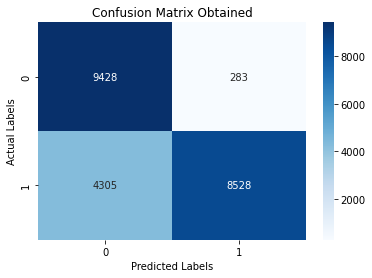

Accuarcy value obtained is  0.7965
F1-score obtained is  0.788
Precision obtained is  0.9679
Recall obtained is  0.6645


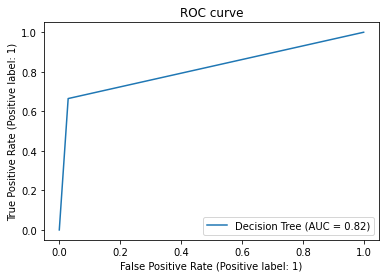

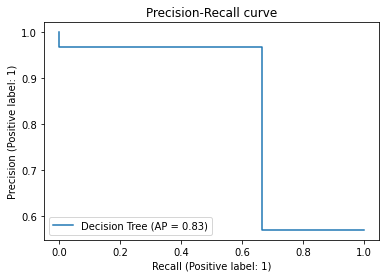

In [25]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=5, random_state=0)
dt.fit(processed_train_data_trX,processed_train_data_trY)
dt_yPred = dt.predict(processed_test_data_X)
#Performance Metrics obtained using Decision Tree
dt_list = ["Decision Tree after Hyperparameter Tuning"]
dt_list.extend(print_metrics(processed_test_data_Y, dt_yPred,"Decision Tree"))
dt_results_table.append(dt_list)

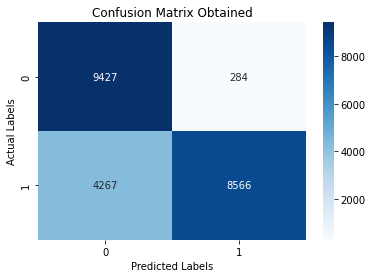

Accuarcy value obtained is  0.7981
F1-score obtained is  0.7901
Precision obtained is  0.9679
Recall obtained is  0.6675


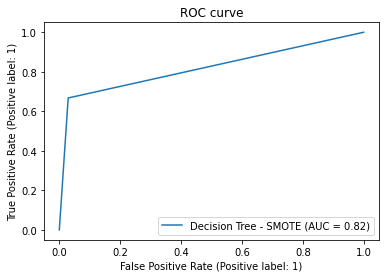

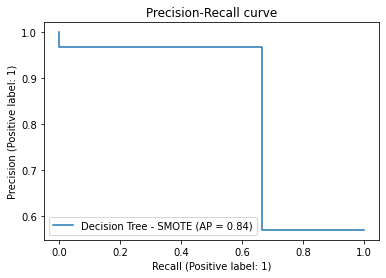

In [26]:
dt_smote = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,random_state=0)
dt_smote.fit(processed_smote_train_data_trX,processed_smote_train_data_trY)
dt_smote_yPred = dt_smote.predict(processed_test_data_X)
#Performance Metrics obtained using Decision Tree
dt_list = ["Decision Tree - SMOTE after Hyperparameter Tuning"]
dt_list.extend(print_metrics(processed_test_data_Y, dt_smote_yPred,"Decision Tree - SMOTE"))
dt_results_table.append(dt_list)

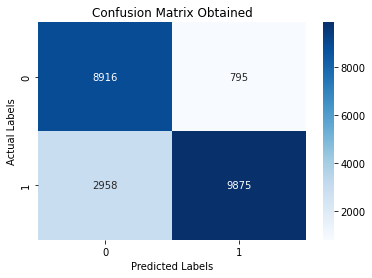

Accuarcy value obtained is  0.8335
F1-score obtained is  0.8403
Precision obtained is  0.9255
Recall obtained is  0.7695


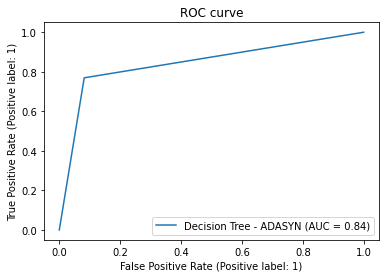

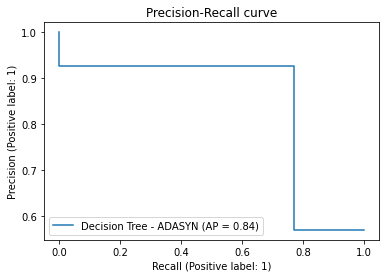

In [27]:
dt_adasyn = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,random_state=0)
dt_adasyn.fit(processed_adasyn_train_data_trX,processed_adasyn_train_data_trY)
dt_adasyn_yPred = dt_adasyn.predict(processed_test_data_X)
#Performance Metrics obtained using Decision Tree
dt_list = ["Decision Tree - ADASYN after Hyperparameter Tuning"]
dt_list.extend(print_metrics(processed_test_data_Y, dt_adasyn_yPred,"Decision Tree - ADASYN"))
dt_results_table.append(dt_list)

In [28]:
dt_results_table

[['Decision Tree', 0.7832, 0.7711, 0.9664, 0.6414],
 ['Decision Tree - SMOTE', 0.7854, 0.7741, 0.966, 0.6458],
 ['Decision Tree - ADASYN', 0.8035, 0.7972, 0.9665, 0.6784],
 ['Decision Tree after Hyperparameter Tuning', 0.7965, 0.788, 0.9679, 0.6645],
 ['Decision Tree - SMOTE after Hyperparameter Tuning',
  0.7981,
  0.7901,
  0.9679,
  0.6675],
 ['Decision Tree - ADASYN after Hyperparameter Tuning',
  0.8335,
  0.8403,
  0.9255,
  0.7695]]

In [29]:
#Tabulating the obtained results and displaying the results by formatting
results_df = pd.DataFrame(dt_results_table,columns = ["Classifier","accuracy","f1-score","Precision","Recall"])
with pd.option_context('display.precision', 4):
    formatted_table=(results_df.style.background_gradient(cmap ='RdYlGn'))
formatted_table

,Classifier,accuracy,f1-score,Precision,Recall
0,Decision Tree,0.7832,0.7711,0.9664,0.6414
1,Decision Tree - SMOTE,0.7854,0.7741,0.9660,0.6458
2,Decision Tree - ADASYN,0.8035,0.7972,0.9665,0.6784
3,Decision Tree after Hyperparameter Tuning,0.7965,0.7880,0.9679,0.6645
4,Decision Tree - SMOTE after Hyperparameter Tuning,0.7981,0.7901,0.9679,0.6675
5,Decision Tree - ADASYN after Hyperparameter Tuning,0.8335,0.8403,0.9255,0.7695


100%|██████████| 34/34 [05:52<00:00, 10.37s/it]


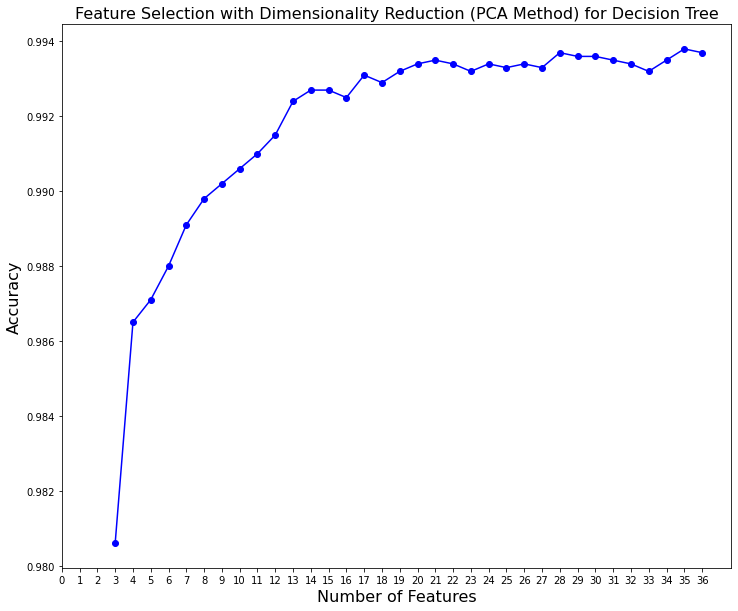

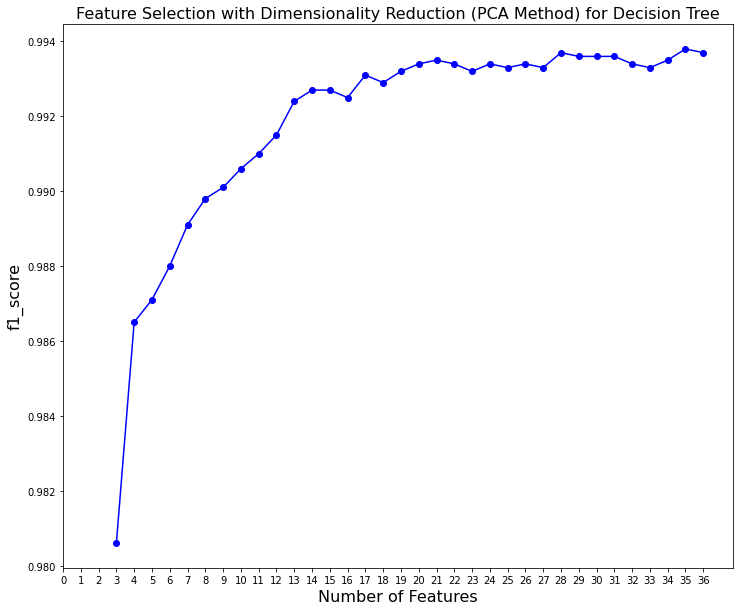

DT Model - Maximum accuracy obtained using PCA is 0.9938 for the number of components = 35
DT Model - Maximum f1-score obtained using PCA is 0.9938 for the number of components = 35


In [34]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)

dt_adasyn = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,random_state=0)
acc_dict = {}
f1_dict = {}

for nf in tqdm(range(3,processed_adasyn_train_data_trX.shape[1]+1)):
    acc_val = []
    f1_val = []
    for train_index,test_index in skf.split(processed_adasyn_train_data_trX,processed_adasyn_train_data_trY):
        X_train, X_test = processed_adasyn_train_data_trX.iloc[train_index], processed_adasyn_train_data_trX.iloc[test_index]
        y_train, y_test = processed_adasyn_train_data_trY.iloc[train_index], processed_adasyn_train_data_trY.iloc[test_index]
        pca = PCA(n_components=nf,random_state=rs)
        pca_train = pca.fit_transform(X_train)
        dt_adasyn.fit(pca_train,y_train)
        pca_test = pca.transform(X_test)
        pca_test_predict = dt_adasyn.predict(pca_test)
        acc_val.append(round(accuracy_score(y_test, pca_test_predict),4))
        f1_val.append(round(f1_score(y_test,pca_test_predict,labels=np.unique(pca_test_predict)),4))
    acc_dict[nf] = round(sum(acc_val)/len(acc_val),4)
    f1_dict[nf] = round(sum(f1_val)/len(f1_val),4)
plt.figure(figsize=(12,10))
plt.plot(*zip(*sorted(acc_dict.items())),color='blue',marker='o')
Title = "Feature Selection with Dimensionality Reduction (PCA Method) for Decision Tree"
plt.title(Title, fontsize=16)
plt.xticks(range(0,processed_adasyn_train_data_trX.shape[1]+1))
plt.xlabel("Number of Features", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.show();
plt.figure(figsize=(12,10))
plt.plot(*zip(*sorted(f1_dict.items())),color='blue',marker='o')
Title = "Feature Selection with Dimensionality Reduction (PCA Method) for Decision Tree"
plt.title(Title, fontsize=16)
plt.xticks(range(0,processed_adasyn_train_data_trX.shape[1]+1))
plt.xlabel("Number of Features", fontsize=16)
plt.ylabel("f1_score", fontsize=16)
plt.show();
acc_adasyn_dt = max(acc_dict.values())
acc_nfea_adasyn_dt=  max(acc_dict, key=acc_dict.get)
f1_adasyn_dt = max(f1_dict.values())
f1_nfea_adasyn_dt=  max(f1_dict, key=f1_dict.get)
print("DT Model - Maximum accuracy obtained using PCA is {} for the number of components = {}".format(acc_adasyn_dt,acc_nfea_adasyn_dt))
print("DT Model - Maximum f1-score obtained using PCA is {} for the number of components = {}".format(f1_adasyn_dt,f1_nfea_adasyn_dt))

In [35]:
def utility_select_feature(processed_adasyn_train_data_trX, processed_adasyn_train_data_trY, fsm, model):
    skf = StratifiedKFold(n_splits=5, random_state=0, shuffle=True)
    acc_val = []
    f1_val = []
    for train_index,test_index in skf.split(processed_adasyn_train_data_trX,processed_adasyn_train_data_trY):
        X_train, X_test = processed_adasyn_train_data_trX.iloc[train_index], processed_adasyn_train_data_trX.iloc[test_index]
        y_train, y_test = processed_adasyn_train_data_trY.iloc[train_index], processed_adasyn_train_data_trY.iloc[test_index]
        fs = fsm.fit(X_train, y_train)
        Xtrain_new = fs.transform(X_train)
        Xtest_new = fs.transform(X_test)
        model.fit(Xtrain_new, y_train)
        yPred = model.predict(Xtest_new)
        acc_val.append(round(accuracy_score(y_test, yPred),4))
        f1_val.append(round(f1_score(y_test,yPred,labels=np.unique(yPred)),4))
    acc = round(sum(acc_val)/len(acc_val),4)
    f1 = round(sum(f1_val)/len(f1_val),4)
    return acc,f1

100%|██████████| 34/34 [12:14<00:00, 21.60s/it]


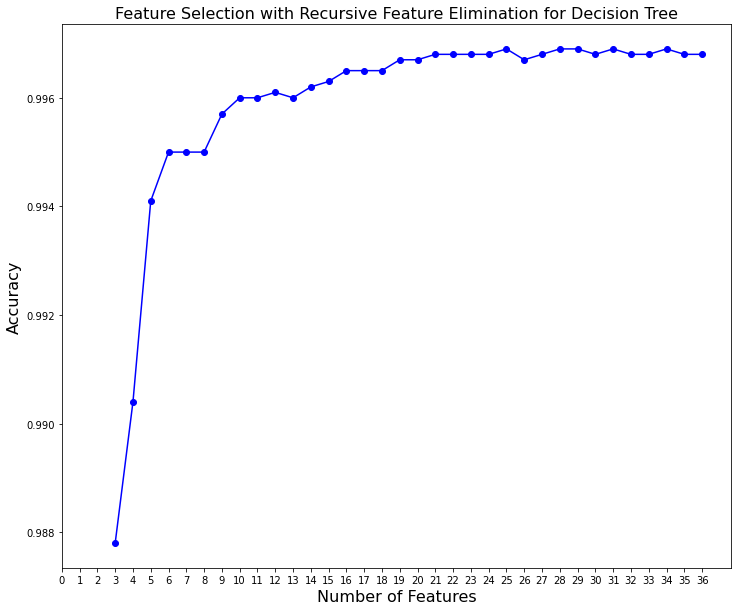

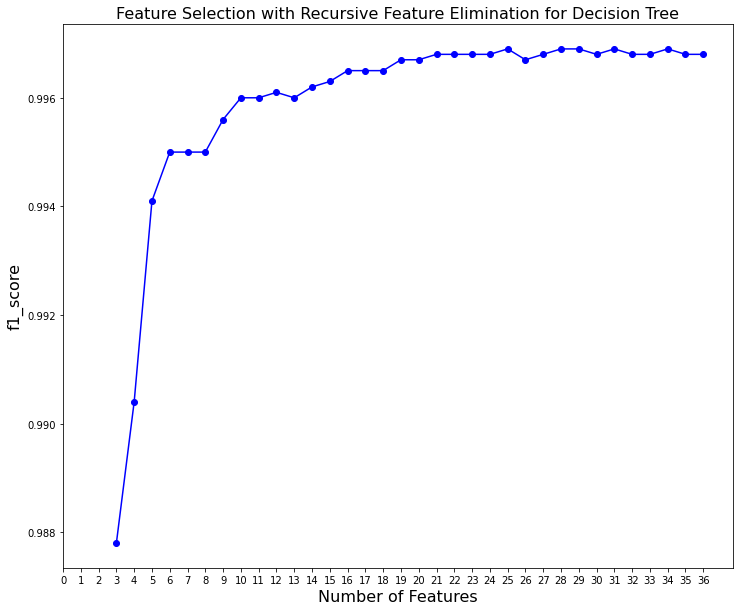

DT Model - Maximum accuracy obtained using Recursive Feature Elimination Method 0.9969 for the number of features = 25
DT Model - Maximum f1-score obtained using Recursive Feature Elimination Method 0.9969 for the number of features = 25


In [37]:
dt_adasyn = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,random_state=0)
acc_dict = {}
f1_dict ={}
for nf in tqdm(range(3,processed_adasyn_train_data_trX.shape[1]+1)):
    rfe = RFE(dt_adasyn, n_features_to_select=nf)
    acc,f1_val = utility_select_feature(processed_adasyn_train_data_trX, processed_adasyn_train_data_trY, rfe, dt_adasyn)
    acc_dict[nf] = acc
    f1_dict[nf] = f1_val

plt.figure(figsize=(12,10))
plt.plot(*zip(*sorted(acc_dict.items())),color='blue',marker='o')
Title = "Feature Selection with Recursive Feature Elimination for Decision Tree"
plt.title(Title, fontsize=16)
plt.xticks(range(0,processed_adasyn_train_data_trX.shape[1]+1))
plt.xlabel("Number of Features", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.show();

plt.figure(figsize=(12,10))
plt.plot(*zip(*sorted(f1_dict.items())),color='blue',marker='o')
Title = "Feature Selection with Recursive Feature Elimination for Decision Tree"
plt.title(Title, fontsize=16)
plt.xticks(range(0,processed_adasyn_train_data_trX.shape[1]+1))
plt.xlabel("Number of Features", fontsize=16)
plt.ylabel("f1_score", fontsize=16)
plt.show();

acc_adasyn_dt = max(acc_dict.values())
acc_nfea_adasyn_dt=  max(acc_dict, key=acc_dict.get)
f1_adasyn_dt = max(f1_dict.values())
f1_nfea_adasyn_dt=  max(f1_dict, key=f1_dict.get)
print("DT Model - Maximum accuracy obtained using Recursive Feature Elimination Method {} for the number of features = {}".format(acc_adasyn_dt,acc_nfea_adasyn_dt))
print("DT Model - Maximum f1-score obtained using Recursive Feature Elimination Method {} for the number of features = {}".format(f1_adasyn_dt,f1_nfea_adasyn_dt))

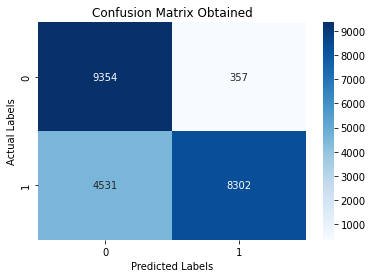

Accuarcy value obtained is  0.7832
F1-score obtained is  0.7726
Precision obtained is  0.9588
Recall obtained is  0.6469


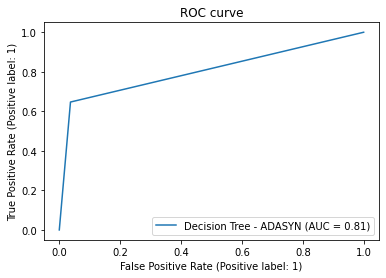

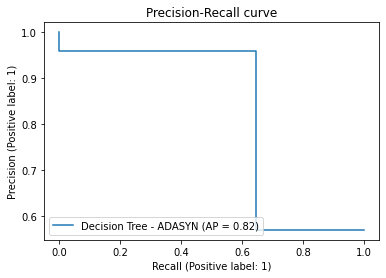

In [38]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,random_state=0)
adasyn = ADASYN(random_state=rs)
pca = PCA(n_components=35,random_state=rs)
dt_pca_pipeline = Pipeline([('adasyn', adasyn), ('pca', pca), ('dt', dt)])
dt_pca_pipeline.fit(processed_train_data_trX,processed_train_data_trY)
dt_pca_pipeline_yPred = dt_pca_pipeline.predict(processed_test_data_X)
dt_list = ["Decision Tree - ADASYN after Hyperparameter Tuning and Feature Selection based on PCA"]
dt_list.extend(print_metrics(processed_test_data_Y, dt_pca_pipeline_yPred,"Decision Tree - ADASYN"))
dt_results_table.append(dt_list)

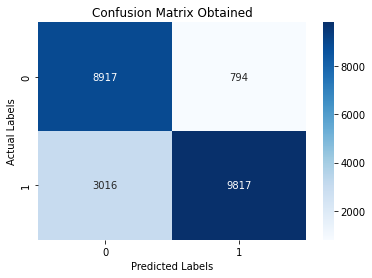

Accuarcy value obtained is  0.831
F1-score obtained is  0.8375
Precision obtained is  0.9252
Recall obtained is  0.765


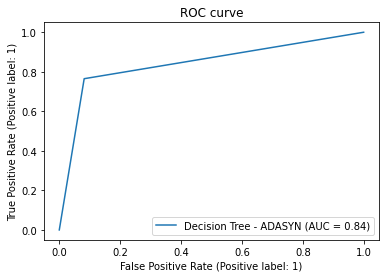

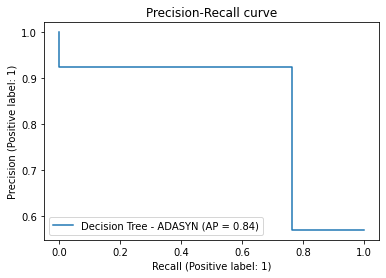

In [39]:
dt = DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,random_state=0)
adasyn = ADASYN(random_state=rs)
rfe = RFE(dt, n_features_to_select=25)
dt_rfe_pipeline = Pipeline([('adasyn', adasyn), ('rfe', rfe), ('dt', dt)])
dt_rfe_pipeline.fit(processed_train_data_trX,processed_train_data_trY)
dt_rfe_pipeline_yPred = dt_rfe_pipeline.predict(processed_test_data_X)
dt_list = ["Decision Tree - ADASYN after Hyperparameter Tuning and Feature Selection based on Recursive Feature Elimination"]
dt_list.extend(print_metrics(processed_test_data_Y, dt_rfe_pipeline_yPred,"Decision Tree - ADASYN"))
dt_results_table.append(dt_list)

In [40]:
dt_results_table

[['Decision Tree', 0.7832, 0.7711, 0.9664, 0.6414],
 ['Decision Tree - SMOTE', 0.7854, 0.7741, 0.966, 0.6458],
 ['Decision Tree - ADASYN', 0.8035, 0.7972, 0.9665, 0.6784],
 ['Decision Tree after Hyperparameter Tuning', 0.7965, 0.788, 0.9679, 0.6645],
 ['Decision Tree - SMOTE after Hyperparameter Tuning',
  0.7981,
  0.7901,
  0.9679,
  0.6675],
 ['Decision Tree - ADASYN after Hyperparameter Tuning',
  0.8335,
  0.8403,
  0.9255,
  0.7695],
 ['Decision Tree - ADASYN after Hyperparameter Tuning and Feature Selection based on PCA',
  0.7832,
  0.7726,
  0.9588,
  0.6469],
 ['Decision Tree - ADASYN after Hyperparameter Tuning and Feature Selection based on Recursive Feature Elimination',
  0.831,
  0.8375,
  0.9252,
  0.765]]

In [41]:
#Tabulating the obtained results and displaying the results by formatting
dt_df = pd.DataFrame(dt_results_table, columns = ["Classifier","accuracy","f1-score","Precision","Recall"])
with pd.option_context('display.precision', 4):
    formatted_table=(dt_df.style.background_gradient(cmap ='RdYlGn'))
formatted_table

,Classifier,accuracy,f1-score,Precision,Recall
0,Decision Tree,0.7832,0.7711,0.9664,0.6414
1,Decision Tree - SMOTE,0.7854,0.7741,0.9660,0.6458
2,Decision Tree - ADASYN,0.8035,0.7972,0.9665,0.6784
3,Decision Tree after Hyperparameter Tuning,0.7965,0.7880,0.9679,0.6645
4,Decision Tree - SMOTE after Hyperparameter Tuning,0.7981,0.7901,0.9679,0.6675
5,Decision Tree - ADASYN after Hyperparameter Tuning,0.8335,0.8403,0.9255,0.7695
6,Decision Tree - ADASYN after Hyperparameter Tuning and Feature Selection based on PCA,0.7832,0.7726,0.9588,0.6469
7,Decision Tree - ADASYN after Hyperparameter Tuning and Feature Selection based on Recursive Feature Elimination,0.8310,0.8375,0.9252,0.7650


In [42]:
dt_df = dt_df.set_index("Classifier")

In [43]:
with pd.option_context('display.precision', 4):
    formatted_table=(dt_df.style.background_gradient(cmap ='RdYlGn'))
formatted_table

,accuracy,f1-score,Precision,Recall
Classifier,,,,
Decision Tree,0.7832,0.7711,0.9664,0.6414
Decision Tree - SMOTE,0.7854,0.7741,0.9660,0.6458
Decision Tree - ADASYN,0.8035,0.7972,0.9665,0.6784
Decision Tree after Hyperparameter Tuning,0.7965,0.7880,0.9679,0.6645
Decision Tree - SMOTE after Hyperparameter Tuning,0.7981,0.7901,0.9679,0.6675
Decision Tree - ADASYN after Hyperparameter Tuning,0.8335,0.8403,0.9255,0.7695
Decision Tree - ADASYN after Hyperparameter Tuning and Feature Selection based on PCA,0.7832,0.7726,0.9588,0.6469
Decision Tree - ADASYN after Hyperparameter Tuning and Feature Selection based on Recursive Feature Elimination,0.8310,0.8375,0.9252,0.7650
